In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import copy

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
sys.path.insert(1, '../..')

In [4]:
from solvers.PoissonSolver import PoissonSolver
from config_step_3 import PARAMS_SOLVER

In [5]:
np.random.seed(seed=123)

In [6]:
PARAMS_SOLVER

{'equation': 'Poisson', 'domain': [0.0, 1.0], 'D': None, 'nx': 101}

D generation

In [114]:
def logn_fct(grid, num_fct, sigma=0.1, centers=None):
    D_logs = []

    if centers is None:
         centers = np.random.uniform(0.2, 0.8, num_fct)
        
    for c in centers:
        D_log = np.exp(-(grid - c)**2 / (2 * sigma**2)) + 1e-1
        D_logs.append(D_log)
    
    return np.stack(D_logs)

In [115]:
x = np.linspace(0., 1., 101)
D = logn_fct(x, 1, centers=[0.5])[0]
PARAMS_SOLVER['D'] = D

In [116]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = PoissonSolver(params=params_solver)

In [117]:
u = solver.solve

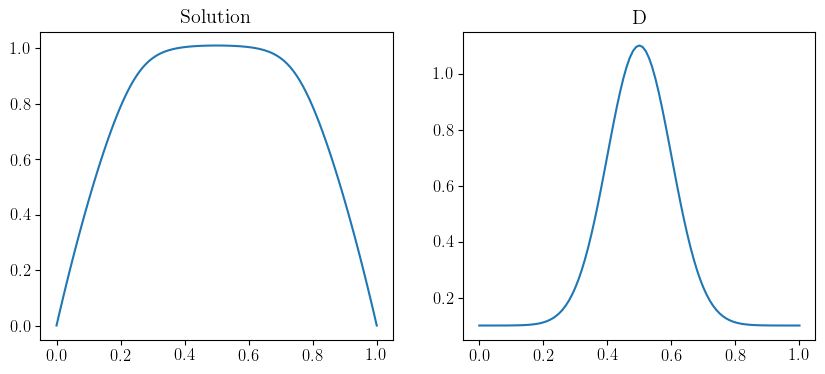

In [118]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(solver.x, u)
ax2.plot(solver.x, D)

ax1.set_title('Solution')
ax2.set_title('D')
plt.show()

In [119]:
VD = logn_fct(x, num_fct=100)

In [120]:
# Vectorized solver
VU = solver.Vsolve(vect = 'D', D = VD)

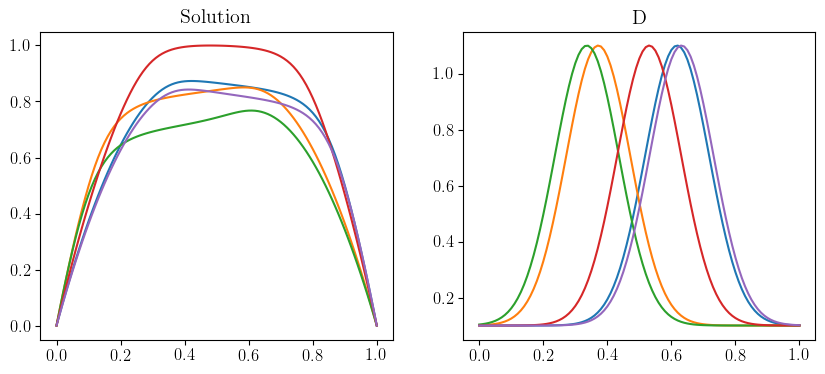

In [121]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
for sample in range(0, 5):
    ax1.plot(solver.x, VU[sample])
    ax2.plot(solver.x, VD[sample])
ax1.set_title('Solution')
ax2.set_title('D')
plt.show()

In [122]:
from methods.DataDrivenMethods import DDMethod

In [123]:
# chose methods that you want to use
method_names = ['POD', 'MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO'] 

In [124]:
from config_step_3 import PARAMS_METHODS, HYPERPARAMS_METHODS

In [125]:
PARAMS_METHODS['MLP']

{'method_name': 'MLP',
 'layer_dims': [2, 24, 28, 11, 18, 21, 1],
 'activations': 'tanh',
 'device': device(type='cpu'),
 'seed': 123}

In [126]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

In [127]:
d_train, d_val, u_train, u_val = sklearn.model_selection.train_test_split(VD, VU, test_size=0.2, random_state=123)

In [128]:
nx = PARAMS_SOLVER['nx']
D_train = torch.Tensor(d_train).flatten().unsqueeze(-1)
D_val = torch.Tensor(d_val).flatten().unsqueeze(-1)

In [129]:
x = torch.Tensor(solver.x).view(-1, 1)
X_train = x.repeat(d_train.shape[0], 1)
X_val = x.repeat(d_val.shape[0], 1)

In [130]:
DX_train = torch.cat((D_train, X_train), dim=1)
DX_val = torch.cat((D_val, X_val), dim=1)
U_train = torch.Tensor(u_train).view(-1, 1)
U_val = torch.Tensor(u_val).view(-1, 1)

In [131]:
D_fno_train = torch.Tensor(d_train).unsqueeze(-1)
D_fno_val = torch.Tensor(d_val).unsqueeze(-1)

In [132]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=VU)
    elif method == 'FNO':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                D_train=D_fno_train, D_val=D_fno_val, U_train=u_train, U_val=u_val)
        
    elif method == 'DEEPONET':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                U_train=u_train, U_val=u_val, D_train=d_train, D_val=d_val)
        
    elif method in ['MLP']:
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                U_train=U_train, U_val=U_val, DX_train=DX_train, DX_val=DX_val, 
                                data_ratio=1., physics_ratio=0.)
        
    elif method == 'PINN':
        all_methods[method].fit(hyperparameters=hyperparams_method, 
                                 DX_train=DX_train, DX_val=DX_val, U_val=U_val, 
                                data_ratio=0., physics_ratio=1., loss='D', w_r=11)
       
    elif method == 'MLPINN':
        all_methods[method].fit(hyperparameters=hyperparams_method, DX_train=DX_train, DX_val=DX_val, U_train=U_train, U_val=U_val,
                           data_ratio=1., physics_ratio=1., loss='D')
        
    # elif method in ['MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO']:
    #     all_methods[method].load_state_dict(f'optuna/step_3/{method}.pt')

Fitting POD
POD fitted
Fitting MLP


[tr : 6.0e-02, val : 6.3e-02]: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 131.47it/s]


MLP fitted
Fitting DEEPONET


[tr : 1.2e-01, val : 1.7e-01]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 29.93it/s]


DEEPONET fitted
Fitting PINN


[tr : 9.4e+00, val : 1.6e-01]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 55.95it/s]


PINN fitted
Fitting MLPINN


[tr : 9.6e+01, val : 4.7e-01]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 28.41it/s]


MLPINN fitted
Fitting FNO


[tr : 3.9e-01, val : 3.9e-01]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.44it/s]

FNO fitted


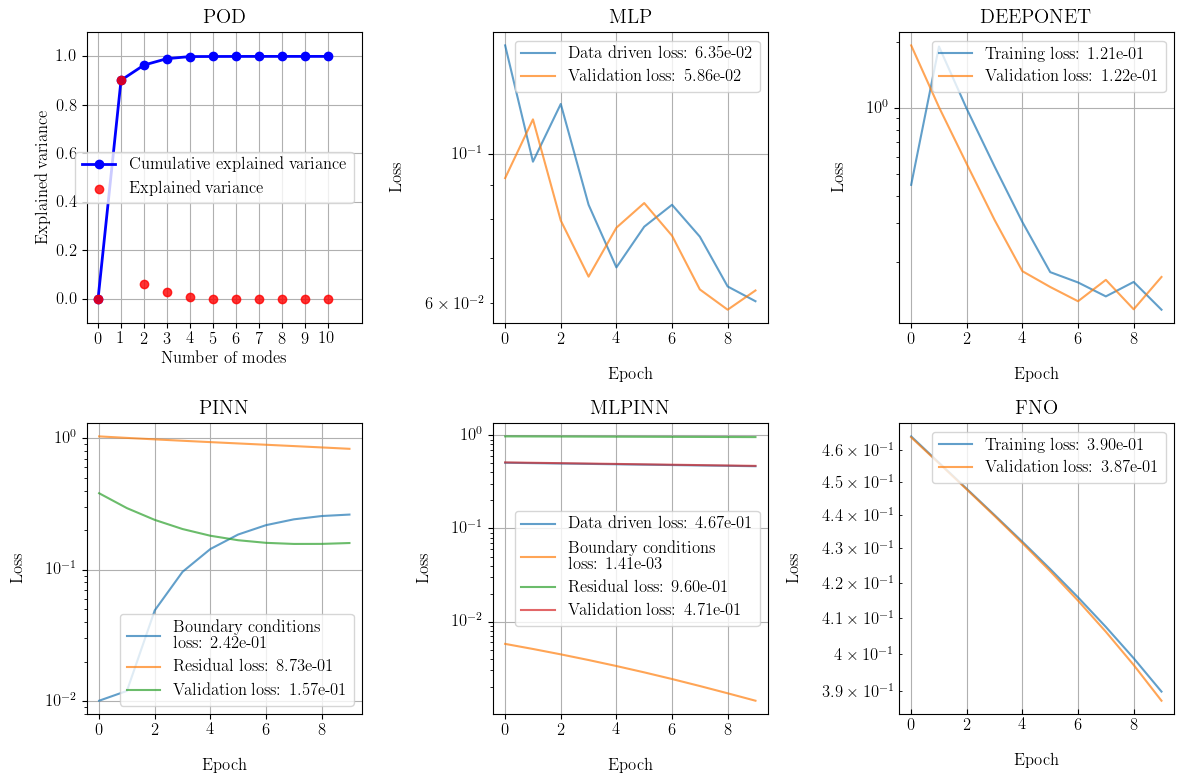

In [133]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) 

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].plot(ax)
    ax.title.set_text(method)
    
fig.tight_layout()
plt.show()

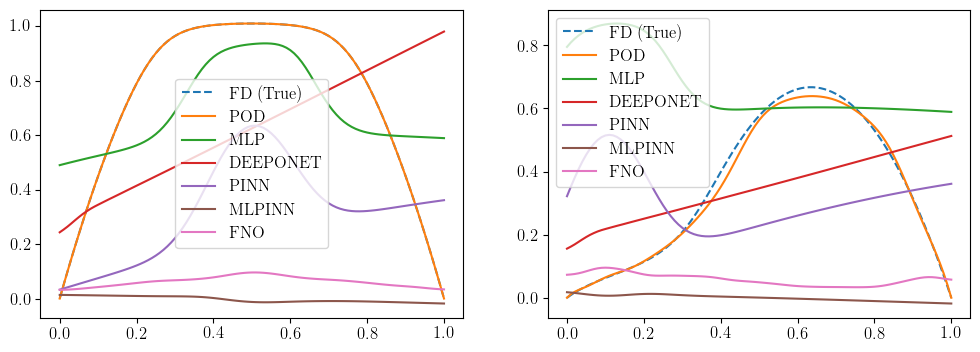

In [134]:
new_D = logn_fct(solver.x, 1, centers=[0.5])[0]
solver.change_D(D=new_D)
U_FD = solver.solve

fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize= (12, 4))
ax_0.plot(solver.x, U_FD, '--', label=f'FD (True)')

for method in all_methods:
    U_pred = all_methods[method].apply_method(phi = new_D, D = new_D).flatten()
    ax_0.plot(solver.x, U_pred, label=f'{method}')
    
# ax_0.title.set_text(f'$a$ = {new_a}')
ax_0.legend()

OOD_D = logn_fct(solver.x, 1, centers=[0.1])[0]
solver.change_D(D=OOD_D)
U_OOD = solver.solve

ax_1.plot(solver.x, U_OOD, '--', label=f'FD (True)')

for method in all_methods:
    U_pred = all_methods[method].apply_method(phi = OOD_D, D = OOD_D).flatten()
    ax_1.plot(solver.x, U_pred, label=f'{method}')
    
# ax_1.title.set_text(f'$a$ = {OOD_a}')
ax_1.legend()
plt.show()

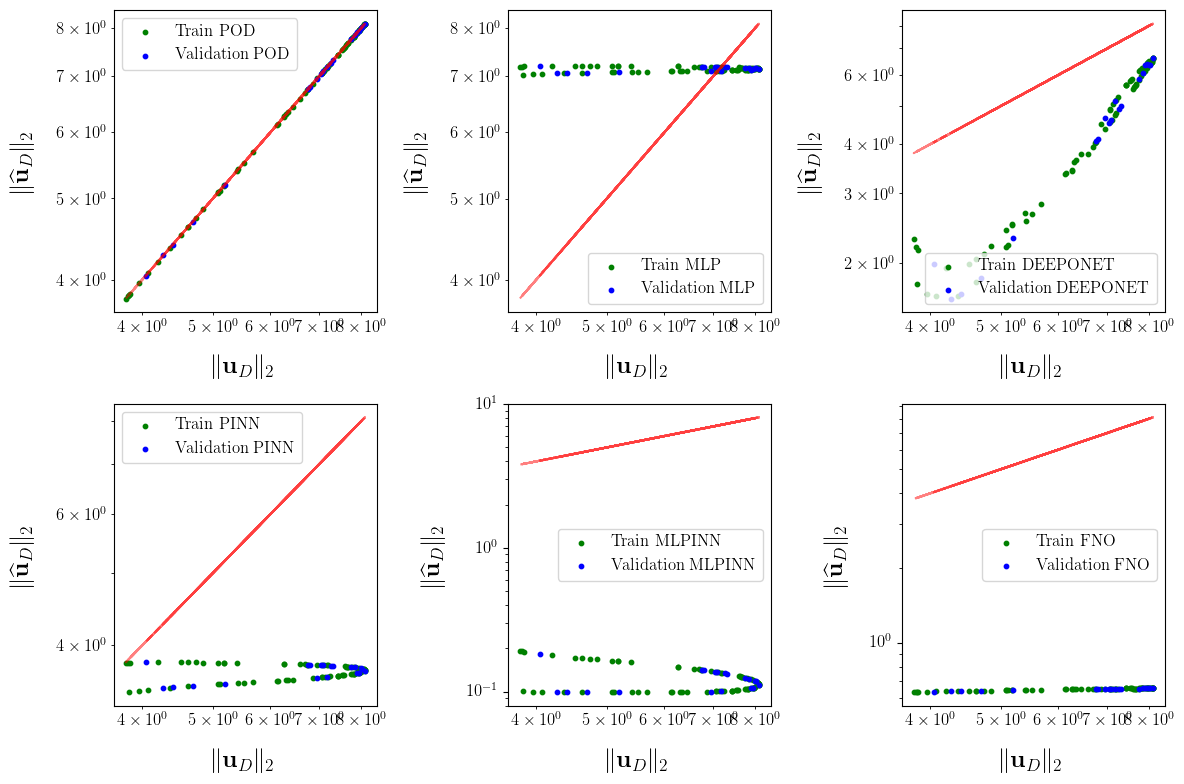

In [135]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].parity_plot(U=u_train, phi=d_train, D=d_train, ax=ax, label=f'Train {method}', color='green')
    all_methods[method].parity_plot(U=u_val, phi=d_val, D=d_val, ax=ax, label=f'Validation {method}', color='blue')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.tight_layout()
plt.show()

In [136]:
#### OUT OF DISTRIBUTION D GENERATION ######
OOD_centers = np.concatenate([np.linspace(0.1, 0.2, 21), np.linspace(0.8, 0.9, 21)])
OOD_VD = logn_fct(solver.x, 1, centers=OOD_centers)
OOD_VU = solver.Vsolve(vect = 'D', D = OOD_VD)
                
OOD_VD = torch.Tensor(OOD_VD)
OOD_VU = torch.Tensor(OOD_VU)

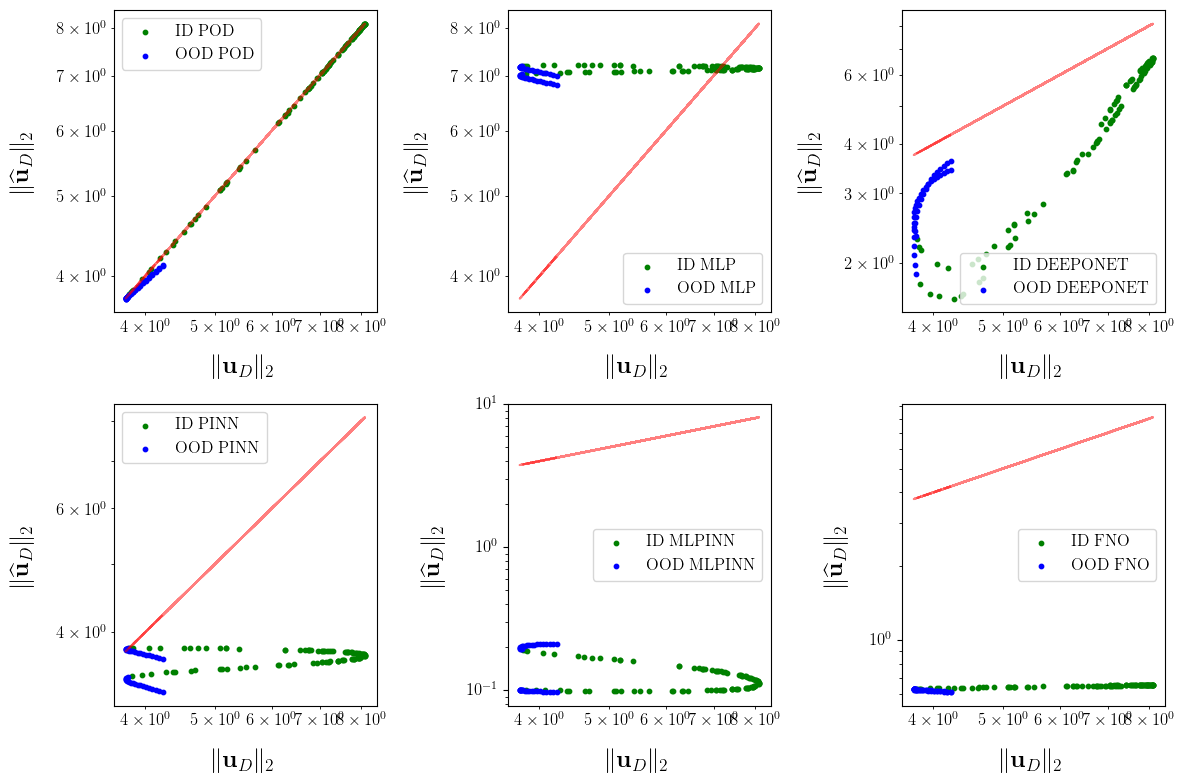

In [137]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].parity_plot(U=VU, phi = VD, D=VD, ax=ax, label=f'ID {method}', color='green')
    all_methods[method].parity_plot(U=OOD_VU, phi= OOD_VD, D=OOD_VD, ax=ax, label=f'OOD {method}', color='blue')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xscale('log')
    
plt.tight_layout()
plt.show()